In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso
from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Numbers display set-up
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# 1) Data Preparation

We are going to use following dataset to train a model for predicting a yearly salary (total compensation) when we are hiring a new employee. This model can help to HR department. Credit to Worksday's tutorial on ML Prague.

In [2]:
df = pd.read_csv('../datasets/linear_regression/hr-data.csv')
df.shape

(5000, 24)

In [3]:
df.head(3)

,compa_ratio,compa_ratio_range,cost_center,country,current_rating,ethnicity,gender,generation,high_performer,high_potential,hiring_source,is_leader,is_manager,job_family_group,job_level,job_profile,length_of_service,location,management_level,region,single_job_family,tenure_category,total_compensation,age
0,1.545,Above Compa-Ratio,AMER - United States of America,United States of America,4 - Exceeds Expectations,Asian,Female,Generation X (1965-1980),False,False,Referral,True,True,Executive,M9,Executive Management - Chief Executive Officer,26.934,San Francisco,Chief Executive Officer,AMER,Executive Management,15+ Years,772400,57.000
1,1.021,At Compa-Ratio,AMER - United States of America,United States of America,3 - Meets Expectations,White,Male,Generation Z (1997 and onwards),False,True,Referral,False,False,Development,P2,IT - Product Development - P2 Business Analytics,1.844,New York,Individual Contributor,AMER,IT - Product Development,01-02 Years,68900,25.000
2,0.981,At Compa-Ratio,Global Support - Asia/Pac,South Korea,5 - Outstanding Performance,Asian,Male,Generation Y/Millenials (1981-1996),True,False,Recruiter,False,False,Development,P3,IT - Product Development - P3 Data Scientist,2.192,Seoul,Individual Contributor,APAC,IT - Product Development,02-05 Years,53200,33.000


In [4]:
df.describe(include="all")

,compa_ratio,compa_ratio_range,cost_center,country,current_rating,ethnicity,gender,generation,high_performer,high_potential,hiring_source,is_leader,is_manager,job_family_group,job_level,job_profile,length_of_service,location,management_level,region,single_job_family,tenure_category,total_compensation,age
count,5000.000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000.000,5000,5000,5000,5000,5000,5000.000,5000.000
unique,NaN,3,5,6,5,5,2,4,2,2,6,2,2,5,13,90,NaN,19,6,3,11,6,NaN,NaN
top,NaN,Above Compa-Ratio,AMER - United States of America,United States of America,4 - Exceeds Expectations,White,Female,Generation Y/Millenials (1981-1996),False,False,Referral,False,False,Development,P4,Board Management - Senior Board Associate,NaN,San Francisco,Individual Contributor,AMER,IT - Product Development,05-10 Years,NaN,NaN
freq,NaN,3284,1275,1275,1013,2282,2500,3364,3992,4227,1531,4674,4409,1476,1334,242,NaN,876,3913,2515,1309,1359,NaN,NaN
mean,1.169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.997,NaN,NaN,NaN,NaN,NaN,131567.360,36.859
std,0.227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.745,NaN,NaN,NaN,NaN,NaN,107949.422,10.741
min,0.639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN,NaN,24600.000,21.000
25%,0.990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.595,NaN,NaN,NaN,NaN,NaN,67500.000,29.000
50%,1.173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.699,NaN,NaN,NaN,NaN,NaN,104300.000,34.000
75%,1.352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.648,NaN,NaN,NaN,NaN,NaN,152700.000,40.000


In [5]:
df.tenure_category.value_counts().index

Index(['05-10 Years', '02-05 Years', '10-15 Years', '15+ Years', '00-01 Years',
       '01-02 Years'],
      dtype='object', name='tenure_category')

In [6]:
df.replace(np.nan, "nan", regex=True, inplace=True)
categorical_columns = df.select_dtypes(include=["object"]).columns
categorical_columns

Index(['compa_ratio_range', 'cost_center', 'country', 'current_rating',
       'ethnicity', 'gender', 'generation', 'hiring_source',
       'job_family_group', 'job_level', 'job_profile', 'location',
       'management_level', 'region', 'single_job_family', 'tenure_category'],
      dtype='object')

In [7]:
ordinal_columns_category_order_dict = {
    'compa_ratio_range': ['Below Compa-Ratio', 'At Compa-Ratio', 'Above Compa-Ratio'],
    'current_rating': ['1 - Unsatisfactory', '2 - Needs Improvement', '3 - Meets Expectations',
                       '4 - Exceeds Expectations', '5 - Outstanding Performance'],
    'tenure_category': ['00-01 Years', '01-02 Years', '02-05 Years', '05-10 Years', '10-15 Years', '15+ Years']
}

In [8]:
df_encoded = df.select_dtypes(exclude=["object"]).copy()
for col in ['high_performer', 'high_potential', 'is_leader', 'is_manager']:
    df_encoded[col] = df_encoded[col].astype(int)
df_encoded.head()

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,total_compensation,age
0,1.545,0,0,1,1,26.934,772400,57.000
1,1.021,0,1,0,0,1.844,68900,25.000
2,0.981,1,0,0,0,2.192,53200,33.000
3,1.342,0,1,0,0,18.518,204600,45.000
4,1.290,0,0,0,0,1.416,70000,32.000


In [9]:
ordinal_encoder = OrdinalEncoder(
    categories=[ordinal_columns_category_order_dict[column] for column in ordinal_columns_category_order_dict.keys()])
df_encoded = df_encoded.join(
    pd.DataFrame(ordinal_encoder.fit_transform(df[ordinal_columns_category_order_dict.keys()]), index=df.index,
                 columns=ordinal_columns_category_order_dict.keys()))
df_encoded.head()

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,total_compensation,age,compa_ratio_range,current_rating,tenure_category
0,1.545,0,0,1,1,26.934,772400,57.000,2.000,3.000,5.000
1,1.021,0,1,0,0,1.844,68900,25.000,1.000,2.000,1.000
2,0.981,1,0,0,0,2.192,53200,33.000,1.000,4.000,2.000
3,1.342,0,1,0,0,18.518,204600,45.000,2.000,1.000,5.000
4,1.290,0,0,0,0,1.416,70000,32.000,2.000,2.000,1.000


In [10]:
nominal_columns = [column for column in categorical_columns if column not in ordinal_columns_category_order_dict.keys()]
df_encoded = df_encoded.join(pd.get_dummies(df[nominal_columns], prefix_sep="="))
df_encoded.head()

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,total_compensation,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Devel

In [11]:
df_encoded.shape

(5000, 186)

# 2) Linear Regression

There are a few assumptions associated with a linear regression model:

* Linearity: The relationship between X and Y is linear.
* Homoscedasticity: The variance of residual is the same for any value of X.
* No multicollinearity: There is no high correlations among two or more independent variables.
* Independence: Observations are independent of each other.
* Normality: For any fixed value of X, Y is normally distributed.

In [12]:
X_data = df_encoded.drop('total_compensation', axis=1)
y_data = df_encoded['total_compensation']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_data, y_data, test_size=0.20, random_state=12
)
column_names = X_train.columns

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
residuals = y_test - y_pred

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)  # Use root_mean_squared_error
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Mean Absolute Percentage Error (MAPE): 953484755.6565572
Root Mean Squared Error (RMSE): 2.32892776769673e+16
R-squared (R²): -5.1001768962783084e+22


In [15]:
residuals.describe()

count                 1000.000
mean       736471625192970.000
std      23289277676967316.000
min                -119030.220
25%                  -6455.220
50%                   -842.220
75%                   6521.780
max     736471625193318272.000
Name: total_compensation, dtype: float64

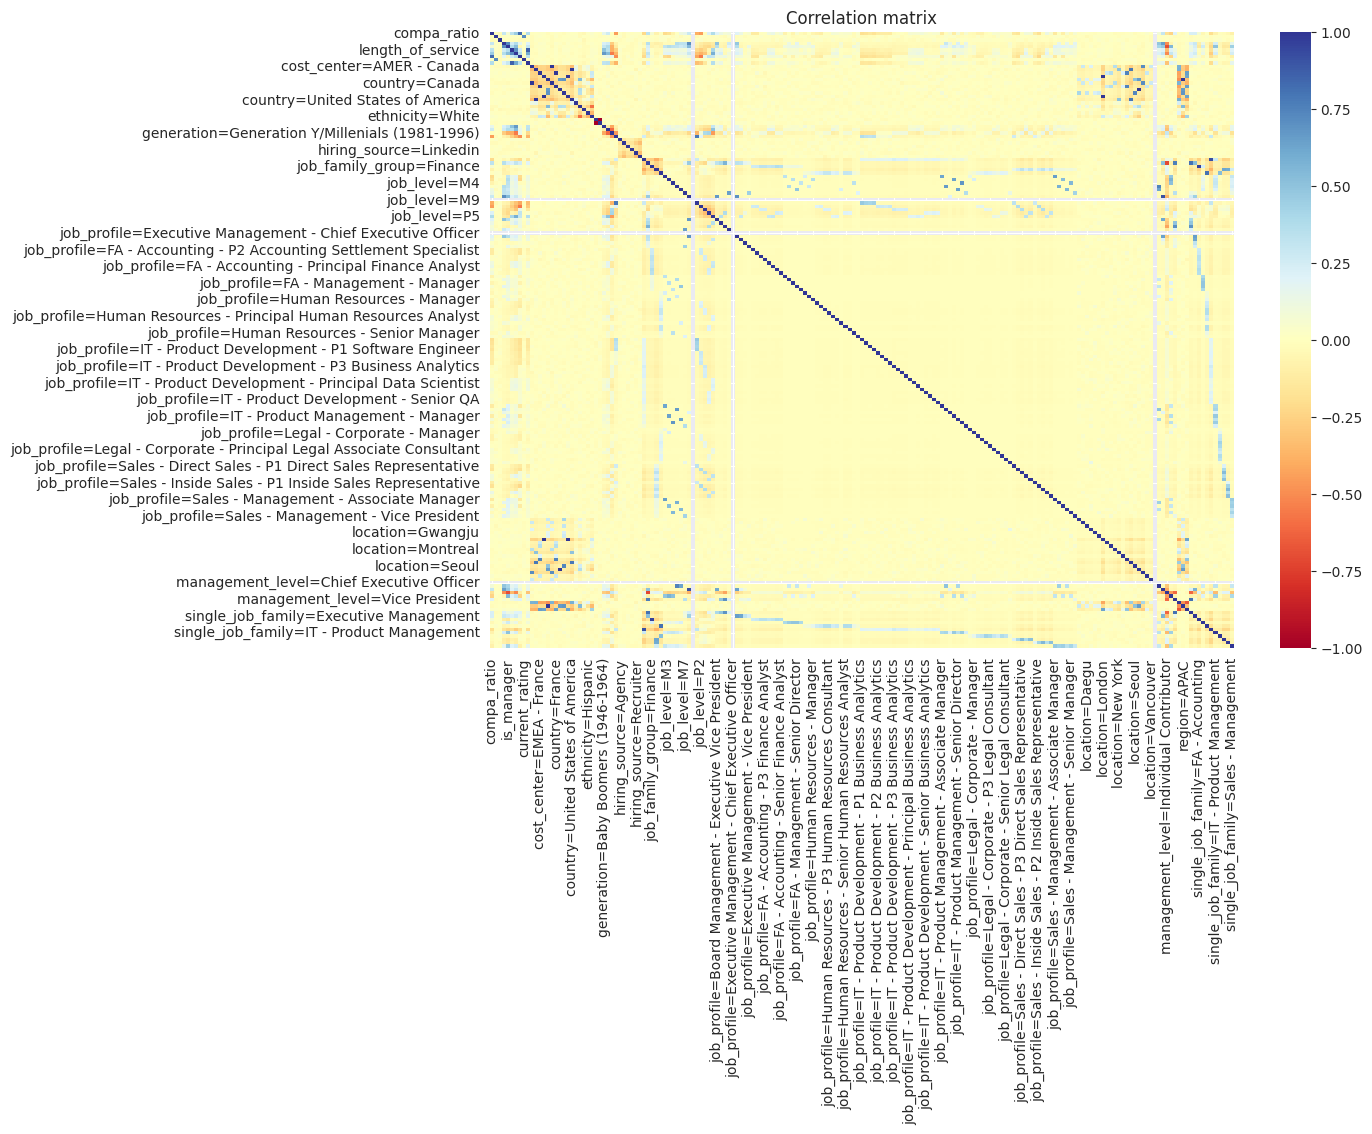

In [16]:
# We broke multicollinearity assumption by using all features
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=False, cmap='RdYlBu', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()
# NOTE: White line represents columns which contain only zeros

# 3) Orthogonal Matching Pursuit

In [17]:
n_coefs = 11
model = OrthogonalMatchingPursuit(n_nonzero_coefs=n_coefs)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
residuals = y_test - y_pred

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.12508973808636517
Root Mean Squared Error: 25115.23968820704
R-squared: 0.9406872778959966


What are the residuals?

In [18]:
residuals.describe()

count      1000.000
mean        -71.508
std       25127.705
min     -136974.590
25%       -9392.462
50%       -2249.060
75%        6910.988
max      465699.425
Name: total_compensation, dtype: float64

How does the target attribute looks like?

<Axes: >

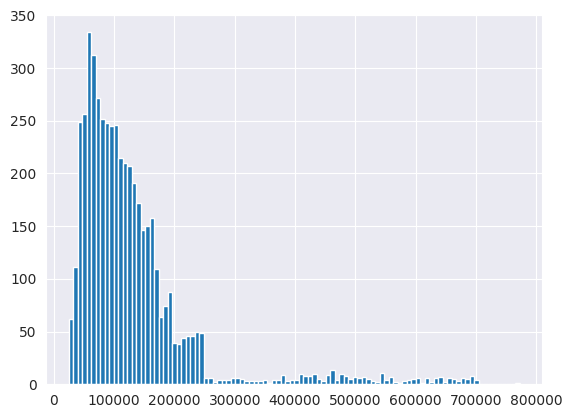

In [19]:
df['total_compensation'].hist(bins=100)

What is the model doing? There is a linear model inside :-).

In [20]:
y_pred = X_test_scaled @ model.coef_ + model.intercept_
y_pred[:5]

array([40012.98749039, 72509.05456051, 26720.48469275, 74277.72802948,
       43852.45827751])

### Use coefficients estimated by OMP to visualize their impact using (e.g.: seaborn, matplotlib). Think about the interpretation of the visualization, especially "age", "job_level -> M8" and "generation -> Baby Boomers (1946 - 1964)".

In [21]:
n_coefs = 11
model = OrthogonalMatchingPursuit(n_nonzero_coefs=n_coefs)
model.fit(X_train_scaled, y_train)

OrthogonalMatchingPursuit(n_nonzero_coefs=11)

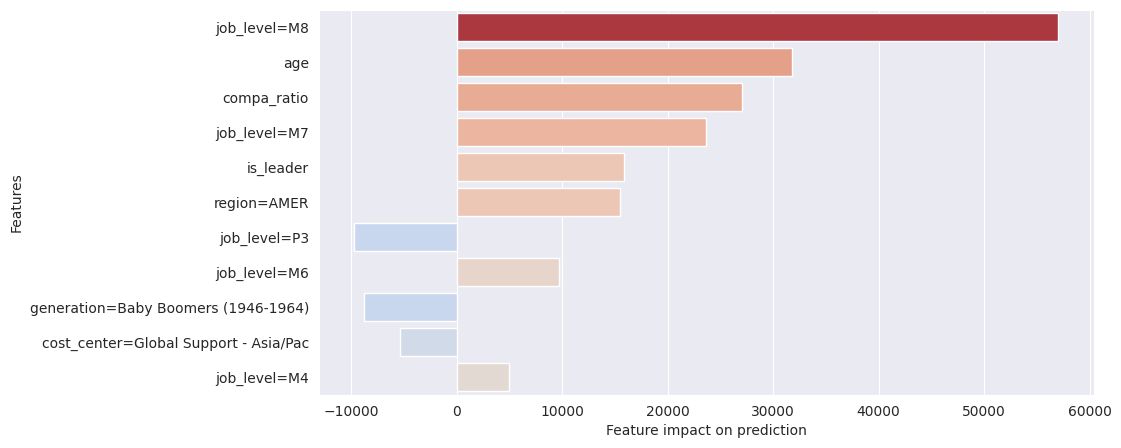

In [22]:
# Visualise the features that have been selected and their respective scores
feature_scores = pd.Series(model.coef_, index=X_data.columns).sort_values(ascending=False, key=lambda x: abs(x))
selected_features = feature_scores[:n_coefs]

f, ax = plt.subplots(figsize=(10, 5))
shades = 31
palette = sns.color_palette('coolwarm', shades)
minmax = np.max([-np.min(selected_features), np.max(selected_features)])
bins = np.linspace(-minmax, minmax, num=shades)
palette_indices = np.digitize(selected_features, bins) - 1
colors = [palette[idx] for idx in palette_indices]

sns.barplot(
    x=selected_features,
    y=selected_features.index,
    dodge=False,
    palette=colors,
    hue=selected_features.index,
    legend=False,
    ax=ax,
    orient="h"
)

ax.set_xlabel('Feature impact on prediction')
ax.set_ylabel('Features')
plt.show()

#### What you can tell about these features?

#### Lets see what a one year change in age can do

In [23]:
X_test.iloc[0:1]

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Development - Principal 

In [24]:
pd.DataFrame(X_test_scaled[0:1, :], columns=X_test.columns)

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Development - Principal 

In [25]:
X_new_entry = X_test.iloc[0:1].copy()
X_new_entry['age'] += 1

In [26]:
pd.DataFrame(scaler.transform(X_new_entry), columns=X_test.columns)

,compa_ratio,high_performer,high_potential,is_leader,is_manager,length_of_service,age,compa_ratio_range,current_rating,tenure_category,cost_center=AMER - Canada,cost_center=AMER - United States of America,cost_center=EMEA - France,cost_center=EMEA - United Kingdom,cost_center=Global Support - Asia/Pac,country=Canada,country=France,country=Singapore,country=South Korea,country=United Kingdom,country=United States of America,ethnicity=American Indian or Alaska Native,ethnicity=Asian,ethnicity=Black or African American,ethnicity=Hispanic,ethnicity=White,gender=Female,gender=Male,generation=Baby Boomers (1946-1964),generation=Generation X (1965-1980),generation=Generation Y/Millenials (1981-1996),generation=Generation Z (1997 and onwards),hiring_source=Agency,hiring_source=Corporate Website,hiring_source=Internal,hiring_source=Linkedin,hiring_source=Recruiter,hiring_source=Referral,job_family_group=Development,job_family_group=Executive,job_family_group=Finance,job_family_group=Sales,job_family_group=Services,job_level=M2,job_level=M3,job_level=M4,job_level=M5,job_level=M6,job_level=M7,job_level=M8,job_level=M9,job_level=P1,job_level=P2,job_level=P3,job_level=P4,job_level=P5,job_profile=Board Management - Executive Vice President,job_profile=Board Management - Principal Board Associate,job_profile=Board Management - Senior Board Associate,job_profile=Board Management - Vice President,job_profile=Executive Management - Chief Executive Officer,job_profile=Executive Management - Executive Vice President,job_profile=Executive Management - Principal Operations Executive,job_profile=Executive Management - Senior Operations Executive,job_profile=Executive Management - Vice President,job_profile=FA - Accounting - P2 Accounting Settlement Specialist,job_profile=FA - Accounting - P2 Finance Analyst,job_profile=FA - Accounting - P3 Accounting Settlement Specialist,job_profile=FA - Accounting - P3 Finance Analyst,job_profile=FA - Accounting - Principal Accounting Settlement Specialist,job_profile=FA - Accounting - Principal Finance Analyst,job_profile=FA - Accounting - Senior Accounting Settlement Specialist,job_profile=FA - Accounting - Senior Finance Analyst,job_profile=FA - Management - Associate Manager,job_profile=FA - Management - Director,job_profile=FA - Management - Manager,job_profile=FA - Management - Senior Director,job_profile=FA - Management - Senior Manager,job_profile=Human Resources - Associate Manager,job_profile=Human Resources - Director,job_profile=Human Resources - Manager,job_profile=Human Resources - P2 Human Resources Analyst,job_profile=Human Resources - P2 Human Resources Consultant,job_profile=Human Resources - P3 Human Resources Analyst,job_profile=Human Resources - P3 Human Resources Consultant,job_profile=Human Resources - Principal Human Resources Analyst,job_profile=Human Resources - Principal Human Resources Consultant,job_profile=Human Resources - Senior Director,job_profile=Human Resources - Senior Human Resources Analyst,job_profile=Human Resources - Senior Human Resources Consultant,job_profile=Human Resources - Senior Manager,job_profile=Human Resources - Vice President,job_profile=IT - Product Development - P1 Business Analytics,job_profile=IT - Product Development - P1 Data Scientist,job_profile=IT - Product Development - P1 QA,job_profile=IT - Product Development - P1 Software Engineer,job_profile=IT - Product Development - P2 Business Analytics,job_profile=IT - Product Development - P2 Data Scientist,job_profile=IT - Product Development - P2 QA,job_profile=IT - Product Development - P2 Software Engineer,job_profile=IT - Product Development - P3 Business Analytics,job_profile=IT - Product Development - P3 Data Scientist,job_profile=IT - Product Development - P3 QA,job_profile=IT - Product Development - P3 Software Engineer,job_profile=IT - Product Development - Principal Business Analytics,job_profile=IT - Product Development - Principal Data Scientist,job_profile=IT - Product Development - Principal 

In [27]:
y_test[0:1]

4506    44500
Name: total_compensation, dtype: int64

In [28]:
model.predict(X_test_scaled[0:1, :])

array([40012.98749039])

In [29]:
model.predict(scaler.transform(X_new_entry))

array([42974.87222143])

## Run again Linear Regression only for selected features. Did the feature selection resolves original problem?

In [30]:
selected_features.index

Index(['job_level=M8', 'age', 'compa_ratio', 'job_level=M7', 'is_leader',
       'region=AMER', 'job_level=P3', 'job_level=M6',
       'generation=Baby Boomers (1946-1964)',
       'cost_center=Global Support - Asia/Pac', 'job_level=M4'],
      dtype='object')

In [31]:
model = LinearRegression()
model.fit(pd.DataFrame(X_train_scaled, columns=X_train.columns)[selected_features.index], y_train)
y_pred = model.predict(pd.DataFrame(X_test_scaled, columns=X_test.columns)[selected_features.index])
residuals = y_test - y_pred

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)  # Updated to root_mean_squared_error
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.12508973808636548
Root Mean Squared Error: 25115.23968820702
R-squared: 0.9406872778959967


# 3) Random Forest and Boruta feature selection

* https://medium.com/geekculture/boruta-feature-selection-explained-in-python-7ae8bf4aa1e7

In [32]:
# Install package not available in Colab by default
# !pip install boruta

### Specify a base RF model and use it to run Boruta feature selection

In [33]:
from boruta import BorutaPy

In [34]:
# Base RF model specification
rf = RandomForestRegressor(max_depth=20, random_state=123)

In [35]:
 # Boruta feature search
feat_selector = BorutaPy(
    verbose=2,
    estimator=rf,
    n_estimators=20,
    max_iter=25,
    random_state=123
)

feat_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	2 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	3 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	4 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	5 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	6 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	7 / 25
Confirmed: 	0
Tentative: 	185
Rejected: 	0
Iteration: 	8 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	9 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	10 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	11 / 25
Confirmed: 	22
Tentative: 	5
Rejected: 	158
Iteration: 	12 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	13 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	14 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	15 / 25
Confirmed: 	22
Tentative: 	3
Rejected: 	160
Iteration: 	16 / 25
Confirmed: 	22
Tentative: 	3
Rejecte

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=20,
                                         random_state=RandomState(MT19937) at 0x7FEE2A828040),
         max_iter=25, n_estimators=20,
         random_state=RandomState(MT19937) at 0x7FEE2A828040, verbose=2)

In [36]:
# Get the list of selected features
boruta_selected = []

for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i] or feat_selector.support_weak_[i]:
        boruta_selected.append(X_train.columns[i])
        print(X_train.columns[i])

compa_ratio
is_leader
is_manager
age
cost_center=Global Support - Asia/Pac
job_level=M4
job_level=M5
job_level=M6
job_level=M7
job_level=M8
job_level=P1
job_level=P2
job_level=P3
job_level=P4
job_level=P5
job_profile=Executive Management - Executive Vice President
job_profile=Executive Management - Vice President
management_level=Director
management_level=Executive Vice President
management_level=Vice President
region=AMER
region=APAC
region=EMEA


In [37]:
print('Number of selected features: ', len(boruta_selected))

Number of selected features:  23


### Run RF model with features selected by Boruta

In [38]:
# Get subsets of explanatory variables only with features that were selected
X_filtered_train = X_train[boruta_selected]
X_filtered_test = X_test[boruta_selected]

In [39]:
# Model specification 
rf = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)

# Fit the model
rf.fit(X_filtered_train, y_train)

# Get predictions
y_pred_BR_sel = rf.predict(X_filtered_test)

In [40]:
rmse = root_mean_squared_error(y_test, y_pred_BR_sel)
r2 = r2_score(y_test, y_pred_BR_sel)
mape = mean_absolute_percentage_error(y_test, y_pred_BR_sel)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.004961502884308441
Root Mean Squared Error: 7398.123120025602
R-squared: 0.9948534486445018


### Run RF model with all features

In [41]:
# Model specification
rf = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)

# Fit the model
rf.fit(X_train, y_train)

# Get predictions
y_pred_rf = rf.predict(X_test)

In [42]:
rmse = root_mean_squared_error(y_test, y_pred_BR_sel)
r2 = r2_score(y_test, y_pred_BR_sel)
mape = mean_absolute_percentage_error(y_test, y_pred_BR_sel)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Percentage Error (MAPE): 0.004961502884308441
Root Mean Squared Error: 7398.123120025602
R-squared: 0.9948534486445018


# Tasks


## Task 1: Use a *feature_importance* param in Random Forest (RF) for feature selection
1. Fit RF model without feature selection
2. Select the most important features using variable importance scores
    - Visualize the value of *feature_importance* for attributes
3. Fit the RF model again, now with selected features only

In [43]:
def evaluate_model(y_test, y_pred):
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return rmse, r2, mape

In [44]:
def print_model_scores(model_name, rmse, r2, mape):
    print(f"Model: {model_name}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}\n")

### Fit RF model without feature selection

In [45]:
rf_all = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)
rf_all.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=50, random_state=123)

#### Calculate the prediction scores for the model with all features

In [46]:
X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)

y_pred_rf_all = rf_all.predict(X_test_aligned)

rmse_all, r2_all, mape_all = evaluate_model(y_test, y_pred_rf_all)
print_model_scores("Random Forest with all features", rmse_all, r2_all, mape_all)

Model: Random Forest with all features
Mean Absolute Percentage Error (MAPE): 0.006767382522046515
Root Mean Squared Error (RMSE): 7971.37300524934
R-squared (R²): 0.994024978604095



#### Select the most important features using variable importance scores

In [47]:
rf_importance = rf.feature_importances_
rf_selected = []

for i in range(len(rf_importance)):
    if rf_importance[i] > 0.01:
        rf_selected.append((X_train.columns[i], rf_importance[i]))

# print them in sorted order
for feature, importance in sorted(rf_selected, key=lambda x: x[1], reverse=True):
    print(feature, importance)

is_leader 0.6013387438582184
age 0.1603596883169118
management_level=Director 0.07085092552338461
region=AMER 0.04709913805857089
compa_ratio 0.04004132749001474
job_level=M8 0.031622170164610684


In [48]:
print('Number of selected features: ', len(rf_selected))

Number of selected features:  6


### Fit the RF model again, now with selected features only

In [49]:
rf_selected_features = [feature for feature, _ in rf_selected]

rf_selected = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)

rf_selected.fit(X_train[rf_selected_features], y_train)

RandomForestRegressor(max_depth=20, n_estimators=50, random_state=123)

#### Calculate the prediction scores for the model with selected features

In [50]:
y_pred_rf_sel = rf_selected.predict(X_test[rf_selected_features])

In [51]:
rmse, r2, mape = evaluate_model(y_test, y_pred_rf_sel)
print_model_scores("Random Forest with selected features", rmse, r2, mape)

Model: Random Forest with selected features
Mean Absolute Percentage Error (MAPE): 0.05316169943503391
Root Mean Squared Error (RMSE): 17902.453968408092
R-squared (R²): 0.9698631169311139



#### Visualize the value of *feature_importance* for attributes

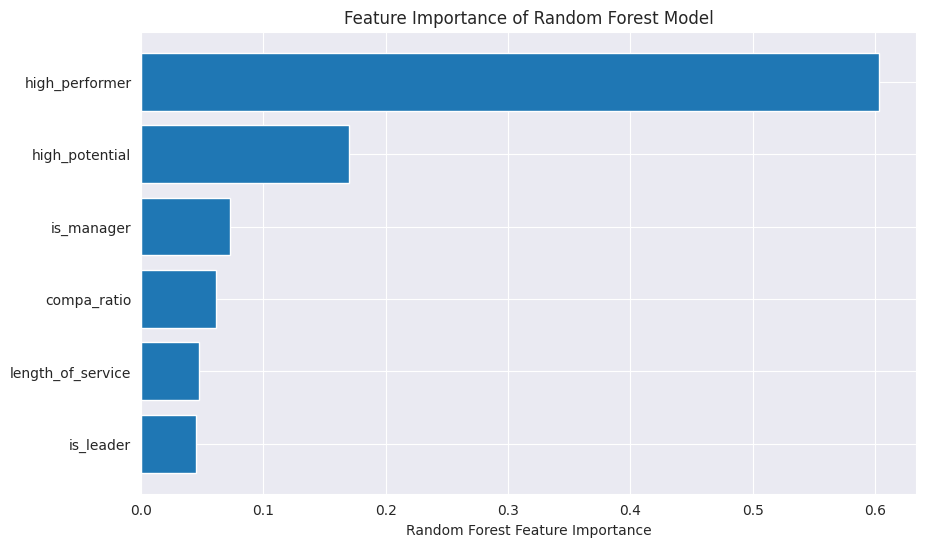

In [52]:
# Sort the features by importance
sorted_idx = rf_selected.feature_importances_.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[sorted_idx], rf_selected.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("Feature Importance of Random Forest Model")
plt.show()

### Compare the results of RF model with all features and selected features

In [53]:
print(f"Mean Absolute Percentage Error (MAPE) for all features: {mape_all}")
print(f"Mean Absolute Percentage Error (MAPE) for selected features: {mape}")
print(f"Difference in MAPE: {mape_all - mape}\n")

print(f"Root Mean Squared Error (RMSE) for all features: {rmse_all}")
print(f"Root Mean Squared Error (RMSE) for selected features: {rmse}")
print(f"Difference in RMSE: {rmse_all - rmse}\n")

print(f"R-squared (R²) for all features: {r2_all}")
print(f"R-squared (R²) for selected features: {r2}")
print(f"Difference in R-squared: {r2_all - r2}")

Mean Absolute Percentage Error (MAPE) for all features: 0.006767382522046515
Mean Absolute Percentage Error (MAPE) for selected features: 0.05316169943503391
Difference in MAPE: -0.0463943169129874

Root Mean Squared Error (RMSE) for all features: 7971.37300524934
Root Mean Squared Error (RMSE) for selected features: 17902.453968408092
Difference in RMSE: -9931.08096315875

R-squared (R²) for all features: 0.994024978604095
R-squared (R²) for selected features: 0.9698631169311139
Difference in R-squared: 0.024161861672981066


### Conclusion

Using all features results in significantly better performance across all evaluated metrics compared to using only the selected features.

- **Mean Absolute Percentage Error (MAPE)**: Much lower with all features (0.0068 compared to 0.0532), indicating a more accurate model.
- **Root Mean Squared Error (RMSE)**: Substantially lower when using all features (7,971 compared to 17,902), reflecting a better fit of the model to the data.
- **R-squared (R²)**: Higher with all features (0.994 compared to 0.970), meaning the model with all features explains more of the variability in the data.

While feature selection simplifies the model and can improve interpretability or reduce computational requirements, it comes at a noticeable cost to performance. The selected features do not capture the complexity and variability of the dataset as effectively as the full feature set, leading to increased error and reduced predictive power.

#### Implications:
If the priority is achieving maximum predictive accuracy, it is better to retain all features. This ensures the lowest error and the highest explanatory power. On the other hand, if model simplicity, interpretability, or resource constraints are important considerations, feature selection remains a valid approach. However, it is crucial to refine the selection process to minimize the loss of performance and ensure that the reduced feature set captures the most relevant aspects of the data. The final decision should be guided by the specific requirements and constraints of the application.



## Task 2: Summarize the insights gained in this analysis
Try some other regression model. You can choose different algorithm or different parameters.

Create a conlusion for this analysis. You can write about something from following list:
- Report the prediction scores achived by various models.
- What features were found important when solving this regression task?

Imagine, you are presenting these results to HR deparment team. Did you get any relevant information for that presentation in this analysis?

### Additional Regression Models

My choice for additional model is Gradient Boosting: A boosting ensemble method that builds multiple decision trees sequentially, with each tree correcting the errors of its predecessor!

In [54]:
rf_all = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)
gb_all = GradientBoostingRegressor(n_estimators=50, max_depth=20, random_state=123)

#### Fit the models for all features

In [55]:
rf_all.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=50, random_state=123)

In [56]:
gb_all.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=20, n_estimators=50, random_state=123)

#### Get predictions and evaluate the models

In [57]:
y_pred_rf = rf_all.predict(X_test)
y_pred_gb = gb_all.predict(X_test)

In [58]:
rmse_rf_all, r2_rf_all, mape_rf_all = evaluate_model(y_test, y_pred_rf)
rmse_gb_all, r2_gb_all, mape_gb_all = evaluate_model(y_test, y_pred_gb)

#### Print the scores for the models

In [59]:
print_model_scores("Random Forest", rmse_rf_all, r2_rf_all, mape_rf_all)
print_model_scores("Gradient Boosting", rmse_gb_all, r2_gb_all, mape_gb_all)

Model: Random Forest
Mean Absolute Percentage Error (MAPE): 0.006767382522046515
Root Mean Squared Error (RMSE): 7971.37300524934
R-squared (R²): 0.994024978604095

Model: Gradient Boosting
Mean Absolute Percentage Error (MAPE): 0.008695053927766549
Root Mean Squared Error (RMSE): 7382.55045838896
R-squared (R²): 0.9948750922831688



### Fit the models for selected features

#### Get the list of selected features

In [60]:
rf_importance = rf_all.feature_importances_
rf_selected = []

for i in range(len(rf_importance)):
    if rf_importance[i] > 0.01:
        rf_selected.append(X_train.columns[i])

#### Model specification

In [61]:
rf_selected = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=123)
gb_selected = GradientBoostingRegressor(n_estimators=50, max_depth=20, random_state=123)

#### Fit the models

In [62]:
rf_selected.fit(X_train[rf_selected_features], y_train)

RandomForestRegressor(max_depth=20, n_estimators=50, random_state=123)

In [63]:
gb_selected.fit(X_train[rf_selected_features], y_train)

GradientBoostingRegressor(max_depth=20, n_estimators=50, random_state=123)

#### Get predictions for the selected features

In [64]:
y_pred_rf_sel = rf_selected.predict(X_test[rf_selected_features])
y_pred_gb_sel = gb_selected.predict(X_test[rf_selected_features])

In [65]:
# Evaluate the models
rmse_rf_sel, r2_rf_sel, mape_rf_sel = evaluate_model(y_test, y_pred_rf_sel)
rmse_gb_sel, r2_gb_sel, mape_gb_sel = evaluate_model(y_test, y_pred_gb_sel)

#### Print the scores for the models

In [66]:
print_model_scores("Random Forest", rmse_rf_sel, r2_rf_sel, mape_rf_sel)
print_model_scores("Gradient Boosting", rmse_gb_sel, r2_gb_sel, mape_gb_sel)

Model: Random Forest
Mean Absolute Percentage Error (MAPE): 0.05316169943503391
Root Mean Squared Error (RMSE): 17902.453968408092
R-squared (R²): 0.9698631169311139

Model: Gradient Boosting
Mean Absolute Percentage Error (MAPE): 0.05813918166570932
Root Mean Squared Error (RMSE): 21557.800944473947
R-squared (R²): 0.9562999316097708



### Overview of Prediction Scores

#### Prediction Scores for Various Models

In [67]:
model_names = ["Random Forest", "Gradient Boosting"]
results_all = pd.DataFrame({
    "Model": model_names,
    "RMSE": [rmse_rf_all, rmse_gb_all],
    "R²": [r2_rf_all, r2_gb_all],
    "MAPE": [mape_rf_all, mape_gb_all]
})

results_sel = pd.DataFrame({
    "Model": model_names,
    "RMSE": [rmse_rf_sel, rmse_gb_sel],
    "R²": [r2_rf_sel, r2_gb_sel],
    "MAPE": [mape_rf_sel, mape_gb_sel]
})

In [68]:
results_sel

,Model,RMSE,R²,MAPE
0,Random Forest,17902.454,0.970,0.053
1,Gradient Boosting,21557.801,0.956,0.058


In [69]:
results_all

,Model,RMSE,R²,MAPE
0,Random Forest,7971.373,0.994,0.007
1,Gradient Boosting,7382.550,0.995,0.009


In [70]:
results_diff = results_all.copy()
results_diff["RMSE"] = results_all["RMSE"] - results_sel["RMSE"]
results_diff["R²"] = results_all["R²"] - results_sel["R²"]
results_diff["MAPE"] = results_all["MAPE"] - results_sel["MAPE"]

results_diff

,Model,RMSE,R²,MAPE
0,Random Forest,-9931.081,0.024,-0.046
1,Gradient Boosting,-14175.250,0.039,-0.049


#### Feature Importance

In [71]:
print("Feature Importance for Random Forest Model:")
feature_importances = rf_selected.feature_importances_
features = X_train.columns

for feature, importance in sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True):
    print(feature, importance)

Feature Importance for Random Forest Model:
high_performer 0.6033255970802
high_potential 0.17017321962822088
is_manager 0.07267654384532125
compa_ratio 0.06127735409027208
length_of_service 0.047548276786496035
is_leader 0.04499900856948966


In [72]:
print("Feature Importance for Gradient Boosting Model:")
feature_importances = gb_selected.feature_importances_
features = X_train.columns

for feature, importance in sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True):
    print(feature, importance)

Feature Importance for Gradient Boosting Model:
high_performer 0.6272964847198189
high_potential 0.1677502019158707
is_manager 0.0780365065237916
compa_ratio 0.0574465232659007
length_of_service 0.049080477027264445
is_leader 0.020389806547353596


### Conclusion

#### Model Performance Summary

In this analysis, we compared the performance of **Random Forest** and **Gradient Boosting** using two sets of results: *selected* models and *all* models.

##### Selected Model Results:
- **Random Forest**: RMSE = 17,902.45, R² = 0.97, MAPE = 5.32%
- **Gradient Boosting**: RMSE = 21,557.80, R² = 0.96, MAPE = 5.81%

##### All Model Results:
- **Random Forest**: RMSE = 7,971.37, R² = 0.99, MAPE = 0.70%
- **Gradient Boosting**: RMSE = 7,382.55, R² = 0.99, MAPE = 0.90%

##### Key Differences:
- **Random Forest**: The RMSE increased by 9,931.08, R² decreased by 0.02, and MAPE worsened by 4.63% in the *selected* set compared to the *all* model results.
- **Gradient Boosting**: RMSE increased by 14,175.25, R² decreased by 0.04, and MAPE worsened by 4.91%.

#### Feature Importance Insights
Both models show stronger performance in the *all* set, with lower RMSE and MAPE, and higher R². The selected models show a noticeable drop in performance, which indicates the potential influence of feature selection or the dataset used for training in the selected set.


#### Feature Importance Summary

This section compares the feature importance values for **Gradient Boosting** and **Random Forest** models.

##### Gradient Boosting Model Feature Importance:
- **high_performer**: 0.63
- **high_potential**: 0.17
- **is_manager**: 0.08
- **compa_ratio**: 0.06
- **length_of_service**: 0.05
- **is_leader**: 0.02

##### Random Forest Model Feature Importance:
- **high_performer**: 0.60
- **high_potential**: 0.17
- **is_manager**: 0.07
- **compa_ratio**: 0.06
- **length_of_service**: 0.05
- **is_leader**: 0.04

##### Key Differences:
- **high_performer** remains the most important feature in both models, with a slightly higher importance in the **Gradient Boosting** model (0.63 vs 0.60).
- **high_potential** shows similar importance in both models (~0.17).
- **is_manager** and **compa_ratio** are more important in the **Gradient Boosting** model, with **is_manager** receiving a higher weight in Gradient Boosting (0.08 vs 0.07).
- **is_leader** has a slightly higher importance in the **Random Forest** model (0.04 vs 0.02), though it's still one of the least important features in both.

##### Conclusion:

The feature importance analysis reveals that **high_performer** is the most critical attribute for predicting total compensation, followed by **high_potential** and **is_manager**. The models agree on the relative importance of these features, with minor differences in the weights assigned to each. The consistency in feature importance across models indicates the robustness of these attributes in predicting total compensation.


#### Presentation Insights / HR Department Relevance

The insights from this analysis provide valuable information for the HR department in making data-driven decisions:

##### Key Insights for HR:
1. **High Performer and High Potential Employees**: Both models emphasize *high_performer* and *high_potential* as the most important features. These employees play a crucial role in the predicted outcomes, suggesting that identifying and nurturing top performers and those with high potential for growth should be a priority for HR.

2. **Managerial Roles**: The feature *is_manager* holds significant importance, particularly in the **Gradient Boosting** model. This indicates that employees in managerial roles are likely to influence the predicted outcomes more than others, making it crucial for HR to focus on leadership development and retention.

3. **Leadership Roles**: While *is_leader* is less important compared to other features, its presence in the model indicates that leadership roles, though secondary, still impact the outcomes. HR may consider providing additional leadership training and opportunities for employees in leadership positions.

4. **Experience (Length of Service)**: *length_of_service* contributes somewhat to the prediction models, suggesting that more experienced employees may have different outcomes. HR can use this to inform decisions related to career development or reward strategies for long-tenured employees.

##### Conclusion:
By leveraging the predictive power of machine learning models, HR can gain valuable insights into the factors influencing total compensation. The identified features provide a roadmap for HR strategies, focusing on high performers, managerial roles, and leadership development to drive organizational success and employee satisfaction.